In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import sklearn.model_selection as model_selection
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import SGD
from numpy import newaxis
import keras
from keras import backend as K
from sklearn.metrics import classification_report
import tensorflow as tf
import io
from tensorflow.keras import layers
from keras.layers import GlobalAveragePooling1D, Conv1D, Conv2D

Using TensorFlow backend.


In [2]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [3]:
import nltk
import os
import pandas as pd
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vishaal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vishaal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vishaal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
os.chdir('../10_Data/20_Extracted Tweets/15_2018 Test')

In [4]:
os.getcwd()

'C:\\Users\\Vishaal\\Documents\\GitHub\\TREC_Distributed_Machine_Learning\\TREC\\30_Models'

In [8]:
os.chdir('../10_2018 Train')

In [9]:
df1 = pd.read_csv('Earthquake_TREC_2018_test.csv')
df2 = pd.read_csv('Floods_TREC_2018_test.csv')
df3 = pd.read_csv('Earthquake_TREC_2018_train.csv')
df4 = pd.read_csv('flood_TREC_2018_train.csv')

In [117]:
df4.head()

,Unnamed: 0,Unnamed: 0.1,ID,Tweet,Event,Retweet_Count,Follower_Count,Source,User_Created_at,Tweet_Created_at,User_Language,User_Screen_Name,User_Location,Event_Decrption,Categories,Priority
0,510,510,378011169883037697,"RT @dlfluegge: Crazy Flooding in Boulder, Colo...",floodColorado2013,10,376,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",2009-07-26 18:15:13,2013-09-12 04:24:20,en,jewmike,Colorado,The 2013 Colorado floods was a natural disaste...,['MultimediaShare'],High
1,511,511,378020179214491649,Here's the #boulderflood video that's circulat...,floodColorado2013,3,211,"<a href=""http://twitter.com/download/iphone"" r...",2010-05-16 21:17:24,2013-09-12 05:00:08,en,KristinsDreams,"Denver, CO",The 2013 Colorado floods was a natural disaste...,['MultimediaShare'],High
2,512,512,378026101588496385,RT @passantino: Video: Severe flooding hits ne...,floodColorado2013,3,621,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",2011-02-02 23:20:53,2013-09-12 05:23:40,en,mindfulnurse,"Boulder, Colorado",The 2013 Colorado floods was a natural disaste...,['MultimediaShare'],High
3,513,513,378029784204206080,"Crazy Flooding in Boulder, Colorado http://t.c...",floodColorado2013,0,232,"<a href=""http://www.apple.com"" rel=""nofollow"">...",2010-04-06 03:59:52,2013-09-12 05:38:18,en,JoshWorldPeace,NaN,The 2013 Colorado floods was a natural disaste...,['MultimediaShare'],High
4,514,514,378038458024865792,Thoughts and prayers out to those in Boulder w...,floodColorado2013,5,188,"<a href=""http://twitter.com/#!/download/ipad"" ...",2010-02-13 05:31:57,2013-09-12 06:12:46,en,jimatgoleaddog,"Lyme & Randolph, NH",The 2013 Colorado floods was a natural disaste...,['Sentiment'],Low


In [10]:
'''
    Combining all into one big data frame
'''
df = pd.DataFrame()
df['Tweet'] = pd.concat([df1['Tweet'] , df2['Tweet'], df3['Tweet'], df4['Tweet']])
df['Priority'] = pd.concat([df1['Priority'] , df2['Priority'], df3['Priority'], df4['Priority']])


In [11]:
df[df['Priority']=='Critical'].shape

(55, 2)

In [12]:
df_low = df[df['Priority'] == 'Low'].sample(55)
df_crit = df[df['Priority'] == 'Critical']
df_c = pd.concat([df_low, df_crit])
df_c = shuffle(df_c)

In [319]:
df_c = pd.read_csv('Ultimate_Dataframe_TREC_2018_Test.csv')
df_c = shuffle(df_c)

In [13]:
'''
Creating a categorical variable to keep label critical tweets as 1 and 0 otherwise
'''
def to_categorical(df_c):
    t = []
    for element in df_c['Priority']:
        if element =='Critical':
            t.append(1)
        else:
            t.append(0)
        
    t = np.array(t)
    df_c['Target'] = t

    df_c['Target'] = df_c['Target'].astype('category')
    t = df_c['Target']
    del df_c['Target']
    return (t)

t = to_categorical(df_c)

In [14]:
'''
    Creating a function to input lemmatized text to possibly another function that outputs the tfidf in a csv format.
    We could also simply use the output from this funtion in an tfidf format (no csv) and train a model.
'''
def preProcess(df):
    df['Tweet'] = df['Tweet'].astype('str')
    
    token_array = []
    for tweet in df['Tweet']:
        token_tweet = word_tokenize(tweet)
        token_array.append(token_tweet)
        
    stop_words=set(stopwords.words("english"))
    filtered_token_array=[]
    for tweet in token_array:
        filtered_tweet = []
        for word in tweet:
                if word not in stop_words:
                    filtered_tweet.append(word)
        filtered_token_array.append(filtered_tweet)
        
    lem = WordNetLemmatizer()
    stem = PorterStemmer()

    lemmatized_array=[]
    for tweet in filtered_token_array:
        lemmatized_tweet = []
        for word in tweet:
            lemmatized_tweet.append(lem.lemmatize(word,'v'))
        lemmatized_array.append(lemmatized_tweet)
    
    lemmatized_array_join = []
    for element in lemmatized_array:
        lemmatized_array_join.append(' '.join(element))
        
    return (lemmatized_array_join)


In [15]:
'''
  We tokenize the lemmatized tweets to then do word embeddings
'''
l = preProcess(df_c)

all_words = []

for tweet in l:
    tokenize_word = word_tokenize(tweet)
    for word in tokenize_word:
        all_words.append(word)
'''
    Getting the unique words out
'''
unique_words = set(all_words)




In [16]:
'''
    Getting embedded sentences
'''
vocab_length = len(unique_words)

embedded_sentences = [one_hot(tweet, vocab_length) for tweet in l]

In [17]:
'''
    Making the size of all embeddings equal to the longest one
'''
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(l, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')

In [18]:
padded_sentences.shape

(110, 35)

In [19]:
vocab_length

958

In [20]:
length_long_sentence 

35

In [31]:
iterations = 1

for i in range (iterations):
   
    '''
        Sample requsite tweets to balance class
    '''
    #df_low = df[df['Priority'] == 'High'].sample(55)
    #df_crit = df[df['Priority'] == 'Critical']
    #df_c = pd.concat([df_low, df_crit])
    #df_c = shuffle(df_c)
    '''
        Categorize label as 0 or 1 (1 comprises of the + class aka critical tweets)
    '''
    t = to_categorical(df_c)

    '''
      We tokenize the lemmatized tweets to then do word embeddings
    '''
    l = preProcess(df_c)
    all_words = []
    for tweet in l:
        tokenize_word = word_tokenize(tweet)
        for word in tokenize_word:
            all_words.append(word)
    '''
        Getting the unique words out
    '''
    unique_words = set(all_words)

    '''
        Getting embedded sentences
    '''
    vocab_length = len(unique_words)
    embedded_sentences = [one_hot(tweet, vocab_length) for tweet in l]

    '''
        Making the size of all embeddings equal to the longest one
    '''
    word_count = lambda sentence: len(word_tokenize(sentence))
    longest_sentence = max(l, key=word_count)
    length_long_sentence = len(word_tokenize(longest_sentence))
    padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')

    '''
        Model Paramters
    '''
    model = keras.Sequential()
    model.add(Embedding(vocab_length, 8, input_length=padded_sentences.shape[1]))
    model.add(LSTM(16, input_shape = (padded_sentences.shape[1], 1), dropout=0.4, return_sequences=True))
    model.add(GlobalAveragePooling1D())
    #model.add(Dense(8, activation = 'relu', input_shape = (padded_sentences.shape[1],)))
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    '''
        Compile and fit model
    '''
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()])

    history = model.fit(padded_sentences, t, batch_size=16, epochs=15, validation_split=0.3)

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 77 samples, validate on 33 samples
Epoch 1/15
77/77 [==============================] - 1s 9ms/step - loss: 0.6936 - acc: 0.4286 - precision_5: 0.1875 - recall_5: 0.0882 - auc_5: 0.4254 - val_loss: 0.6962 - val_acc: 0.3636 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_auc_5: 0.5000
Epoch 2/15
77/77 [==============================] - 0s 1ms/step - loss: 0.6907 - acc: 0.5455 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - auc_5: 0.5188 - val_loss: 0.6987 - val_acc: 0.3636 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_auc_5: 0.6190
Epoch 3/15
77/77 [==============================] - 0s 1ms/step - loss: 0.6884 - acc: 0.5584 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - auc_5: 0.6098 - val_loss: 0.7013 - val_acc: 0.3636 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_auc_5: 0.6310
Epoch 4/15
77/77 [==============================] - 0s 1ms/step - loss: 0.6861 - acc: 0.5584 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - auc_

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 35, 16)            15328     
_________________________________________________________________
lstm_3 (LSTM)                (None, 35, 16)            2112      
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 17,457
Trainable params: 17,457
Non-trainable params: 0
_________________________________________________________________


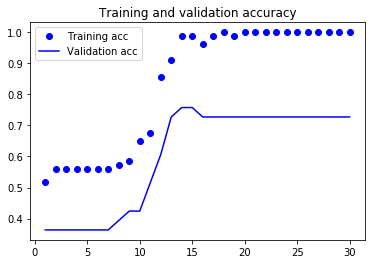

In [28]:
'''
    Plotting accuracy VS epoch for training and validations
'''
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

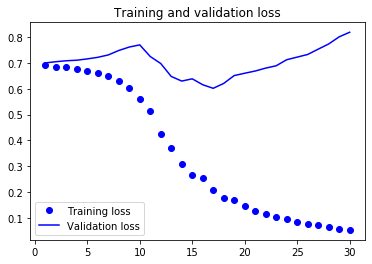

In [29]:

'''
    Plotting loss VS epoch for training and validations
'''
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [650]:
import statistics
precision = [0.9231, 0.5625, 0.4545, 1, 0.5455, 0.5556, 0.75, 1, 1, 0.4318]
recall = [1, 0.3, 0.4848, 1, 1, 1, 0.2273,1, 1, 0.9524]
AUC = [0.7821, 0.8427, 0.8946, 0.8002, 0.8383, 0.8453,0.8874, 0.8, 0.8062, 0.7847 ]
print('Mean Precision = ', statistics.mean(precision))
print('Stdev Precision = ', statistics.stdev(precision))
print('Mean Recall = ', statistics.mean(recall))
print('Stdev Recall = ', statistics.stdev(recall))
print('Mean ROC AUC = ', statistics.mean(AUC))
print('Stdev ROC AUC = ', statistics.stdev(AUC))

Mean Precision =  0.7223
Stdev Precision =  0.23877699033012187
Mean Recall =  0.79645
Stdev Recall =  0.3232536095871338
Mean ROC AUC =  0.82815
Stdev ROC AUC =  0.04027536467867174


In [315]:
    y_pred = model.predict(history.validation_data[0])
len(history.validation_data[1])

33

In [317]:
len(padded_sentences[0])

34

In [ ]:
#leet code, RL, FC, Ian, Coursera...